Tables created: products, dates, sales

ROLAP Queries:

Average Revenue by Category:
       category  avg_revenue
0     Clothing   850.000000
1  Electronics  5333.333333
2    Furniture  1200.000000

Total Revenue by Year:
    year  total_revenue
0  2024          18900

Best-Selling Product in Each Category:
       category    name  total_quantity
0     Clothing   Shirt              20
1     Clothing   Jeans              15
2  Electronics   Phone              22
3  Electronics  Laptop               5
4    Furniture   Chair               8


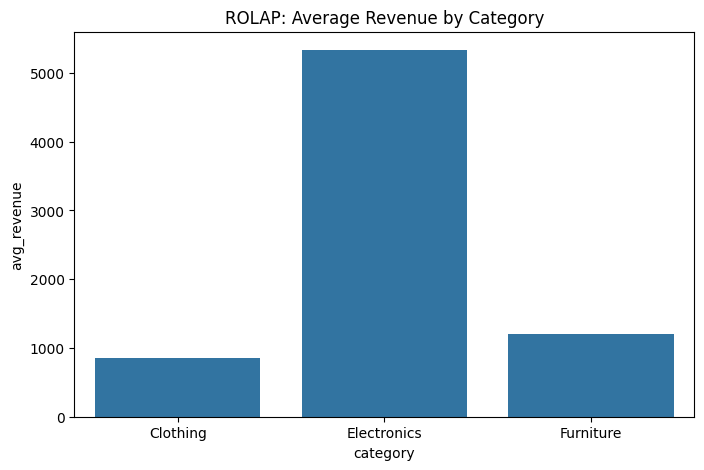

C:\Users\USER\AppData\Local\Temp\ipykernel_124\341891863.py:110: FutureWarning: The provided callable <function sum at 0x00000185FE8222A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  molap_cube = pd.pivot_table(



MOLAP Cube (Revenue by Category grouped by Year):
 year          2024
category          
Clothing      1700
Electronics  16000
Furniture     1200


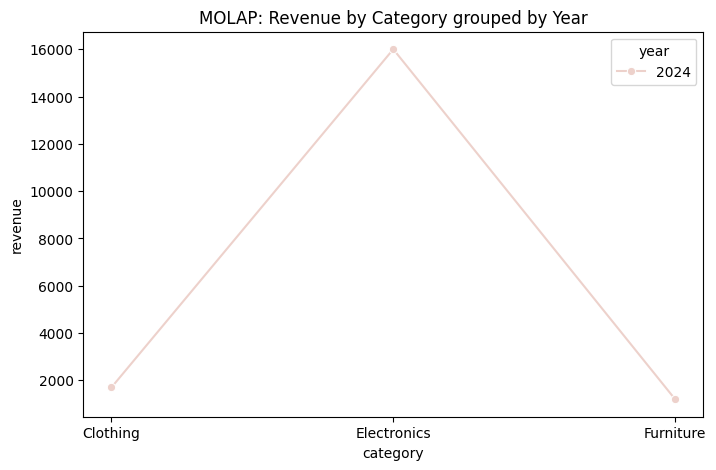


HOLAP Summary (Revenue by Category grouped by Year):
       category  year  revenue
0     Clothing  2024     1700
1  Electronics  2024    16000
2    Furniture  2024     1200


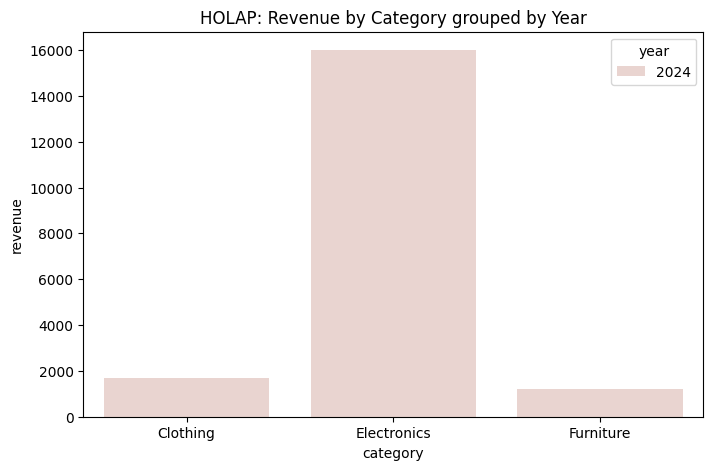


OLAP Operations:

Slice (2024 only):
    sale_id  quantity  revenue     category    name  year  quarter  month
0        1        10     5000  Electronics   Phone  2024        1      1
1        2         5     5000  Electronics  Laptop  2024        1      2
2        3        20      800     Clothing   Shirt  2024        1      3
3        4        15      900     Clothing   Jeans  2024        2      4
4        5         8     1200    Furniture   Chair  2024        3      7
5        6        12     6000  Electronics   Phone  2024        3      9

Dice (Q1 2024, Electronics):
    sale_id  quantity  revenue     category    name  year  quarter  month
0        1        10     5000  Electronics   Phone  2024        1      1
1        2         5     5000  Electronics  Laptop  2024        1      2

Roll-Up (Category grouped by Year):
       category  year  revenue
0     Clothing  2024     1700
1  Electronics  2024    16000
2    Furniture  2024     1200


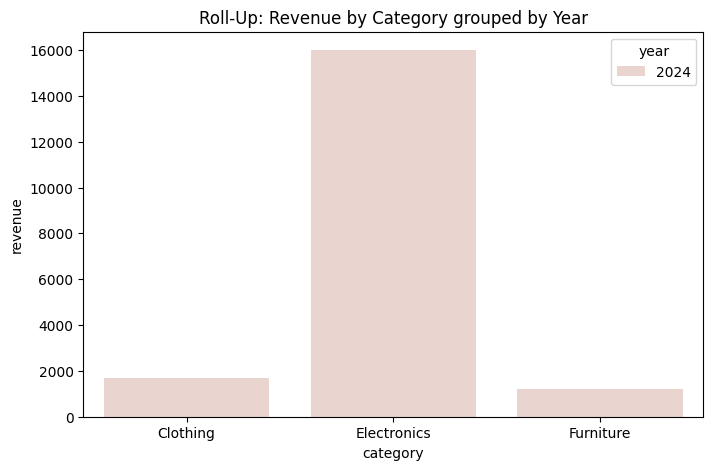


Drill-Down (Year → Quarter → Month):
    year  quarter  month  revenue
0  2024        1      1     5000
1  2024        1      2     5000
2  2024        1      3      800
3  2024        2      4      900
4  2024        3      7     1200
5  2024        3      9     6000


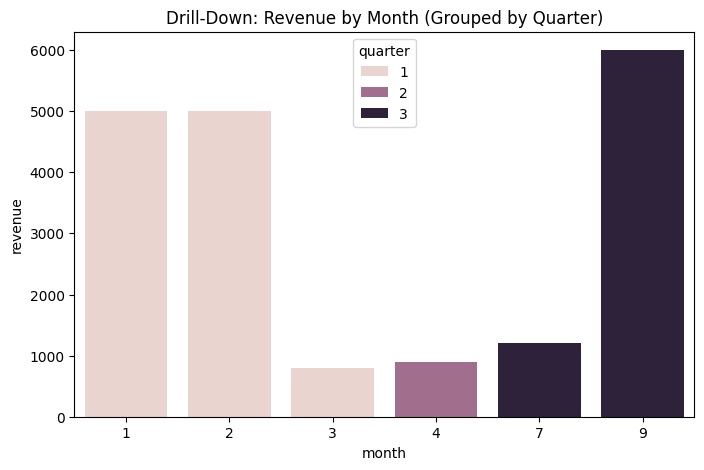

In [ ]:
# OLAP ASSIGNMENT
# Demonstrating ROLAP, MOLAP, HOLAP and OLAP Operations using SQLite + Pandas
# Reference: Class demo structure

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


# Database connection

def create_connection(db_file="olap_assignment.db"):
    return sqlite3.connect(db_file)

conn = create_connection()


# Create sample data (Star Schema: Fact + Dimensions)

# Dimension: Products
products = pd.DataFrame({
    "product_id": [1, 2, 3, 4, 5],
    "category": ["Electronics", "Electronics", "Clothing", "Clothing", "Furniture"],
    "name": ["Phone", "Laptop", "Shirt", "Jeans", "Chair"],
    "price": [500, 1000, 40, 60, 150]
})

# Dimension: Dates
dates = pd.DataFrame({
    "date": pd.to_datetime([
        "2024-01-15", "2024-02-10", "2024-03-12",
        "2024-04-20", "2024-07-05", "2024-09-14"
    ])
})
dates["year"] = dates["date"].dt.year
dates["quarter"] = dates["date"].dt.quarter
dates["month"] = dates["date"].dt.month

# Fact: Sales
sales = pd.DataFrame({
    "sale_id": [1, 2, 3, 4, 5, 6],
    "date": pd.to_datetime([
        "2024-01-15", "2024-02-10", "2024-03-12",
        "2024-04-20", "2024-07-05", "2024-09-14"
    ]),
    "product_id": [1, 2, 3, 4, 5, 1],
    "quantity": [10, 5, 20, 15, 8, 12]
})
sales["revenue"] = sales["quantity"] * sales["product_id"].map(products.set_index("product_id")["price"])

# Load data into SQLite

products.to_sql("products", conn, if_exists="replace", index=False)
dates.to_sql("dates", conn, if_exists="replace", index=False)
sales.to_sql("sales", conn, if_exists="replace", index=False)

print("Tables created: products, dates, sales")

# ROLAP: SQL Queries

print("\nROLAP Queries:")

# Average revenue by category
query1 = """
SELECT p.category, AVG(s.revenue) as avg_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category;
"""
rolap1 = pd.read_sql_query(query1, conn)
print("\nAverage Revenue by Category:\n", rolap1)

# Total sales by year
query2 = """
SELECT d.year, SUM(s.revenue) as total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year;
"""
rolap2 = pd.read_sql_query(query2, conn)
print("\nTotal Revenue by Year:\n", rolap2)

# Best-selling product per category
query3 = """
SELECT p.category, p.name, SUM(s.quantity) as total_quantity
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category, p.name
ORDER BY p.category, total_quantity DESC;
"""
rolap3 = pd.read_sql_query(query3, conn)
print("\nBest-Selling Product in Each Category:\n", rolap3)

# Visualization: ROLAP
plt.figure(figsize=(8, 5))
sns.barplot(data=rolap1, x="category", y="avg_revenue")
plt.title("ROLAP: Average Revenue by Category")
plt.show()


# MOLAP: Pivot (In-memory cube)

merged = sales.merge(products, on="product_id").merge(dates, on="date")

molap_cube = pd.pivot_table(
    merged,
    values="revenue",
    index="category",
    columns="year",
    aggfunc=np.sum,
    fill_value=0
)
print("\nMOLAP Cube (Revenue by Category grouped by Year):\n", molap_cube)

# Visualization: MOLAP line chart
molap_plot = molap_cube.reset_index().melt(id_vars="category", var_name="year", value_name="revenue")
plt.figure(figsize=(8, 5))
sns.lineplot(data=molap_plot, x="category", y="revenue", hue="year", marker="o")
plt.title("MOLAP: Revenue by Category grouped by Year")
plt.show()


# HOLAP: SQL + Pandas combination

detail_sql = """
SELECT s.sale_id, s.quantity, s.revenue, p.category, p.name, d.year, d.quarter, d.month
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date;
"""
detail_df = pd.read_sql_query(detail_sql, conn)

holap_summary = detail_df.groupby(["category", "year"])["revenue"].sum().reset_index()
print("\nHOLAP Summary (Revenue by Category grouped by Year):\n", holap_summary)

# Visualization: HOLAP
plt.figure(figsize=(8, 5))
sns.barplot(data=holap_summary, x="category", y="revenue", hue="year")
plt.title("HOLAP: Revenue by Category grouped by Year")
plt.show()


# OLAP Operations

print("\nOLAP Operations:")

# Slice: 2024 sales only
slice_df = detail_df[detail_df["year"] == 2024]
print("\nSlice (2024 only):\n", slice_df)

# Dice: Q1 2024 & Electronics
dice_df = detail_df[
    (detail_df["year"] == 2024) & 
    (detail_df["quarter"] == 1) & 
    (detail_df["category"] == "Electronics")
]
print("\nDice (Q1 2024, Electronics):\n", dice_df)

# Roll-Up: Product → Category → Year
rollup_df = detail_df.groupby(["category", "year"])["revenue"].sum().reset_index()
print("\nRoll-Up (Category grouped by Year):\n", rollup_df)

# Visualization: Roll-Up
plt.figure(figsize=(8, 5))
sns.barplot(data=rollup_df, x="category", y="revenue", hue="year")
plt.title("Roll-Up: Revenue by Category grouped by Year")
plt.show()

# Drill-Down: Year → Quarter → Month
drilldown_df = detail_df.groupby(["year", "quarter", "month"])["revenue"].sum().reset_index()
print("\nDrill-Down (Year → Quarter → Month):\n", drilldown_df)

# Visualization: Drill-Down
plt.figure(figsize=(8, 5))
sns.barplot(data=drilldown_df, x="month", y="revenue", hue="quarter")
plt.title("Drill-Down: Revenue by Month (Grouped by Quarter)")
plt.show()

conn.close()
